In [ ]:
#word based similarity matching algorithm with threshold based scoring machanishm
import pandas as pd
import re

def load_hs_data(file_path, category_file_path):
    """Load the HS code data and category description data from CSV files."""
    hs_data = pd.read_csv(file_path)
    category_data = pd.read_csv(category_file_path)

    # Merge the data on 'Category' column
    merged_data = pd.merge(hs_data, category_data, on='Category', how='left')
    return merged_data

def preprocess_text(text):
    """Preprocess text by removing special characters and converting to lowercase."""
    if pd.isna(text):
        return ""
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()

def find_hs_code(product_name, hs_data):
    """Find the closest matching HS code and category for a given product name."""
    processed_input = preprocess_text(product_name)
    input_words = set(processed_input.split())

    hs_data['processed_desc'] = hs_data['Description'].apply(preprocess_text)

    best_match = None
    best_score = 0

    for _, row in hs_data.iterrows():
        desc_words = set(row['processed_desc'].split())
        common_words = input_words.intersection(desc_words)
        score = len(common_words) / max(len(input_words), 1)

        if score > best_score:
            best_score = score
            best_match = row

    if best_match is not None and best_score > 0.3:  # Threshold for minimal match
        return (best_match['HS Code'], best_match['Category'],
                best_match['Description'], best_match['Category_Description'])
    else:
        return None, None, None, None

def main():
    hs_file_path = '/content/hs_codes_preprocessed_pro.csv'  # Update with actual file path
    category_file_path = '/content/hs_2_digit_categories_final.csv'  # Update with actual file path
    hs_data = load_hs_data(hs_file_path, category_file_path)

    # Get number of inputs from user
    n = int(input("Enter the number of products: "))
    product_names = [input(f"Enter product name {i+1}: ") for i in range(n)]

    # Process each product name
    for product_name in product_names:
        hs_code, category, description, category_description = find_hs_code(product_name, hs_data)

        if hs_code:
            print(f"\nProduct: {product_name}")
            print(f"Description: {description}")
            print(f"HS Code: {hs_code}")
            print(f"Category: {category}")
            print(f"Category Description: {category_description}")
        else:
            print(f"\nNo matching HS code found for '{product_name}'.")

if __name__ == "__main__":
    main()


Enter the number of products: 1
Enter product name 1: tobacco

Product: tobacco
Description: tobacco not stemmedstripped
HS Code: 240110
Category: 24
Category Description: Tobacco and manufactured tobacco substitutes


In [ ]:
!pip install fuzzywuzzy
!pip install symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 16.8 MB/s eta 0:00:00


In [ ]:
#using td-idf semantic matching
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from symspellpy import SymSpell

# Initialize SymSpell for spelling correction
sym_spell = SymSpell()
sym_spell.load_dictionary("frequency_dictionary_en.txt", term_index=0, count_index=1)

def correct_spelling(text):
    """Correct spelling using SymSpell."""
    text = str(text).lower()
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text

def load_hs_data(file_path, category_file_path):
    """Load and merge HS code data with category descriptions."""
    hs_data = pd.read_csv(file_path)
    category_data = pd.read_csv(category_file_path)
    return pd.merge(hs_data, category_data, on='Category', how='left')

def preprocess_text(text):
    """Basic text cleaning."""
    if pd.isna(text):
        return ""
    text = re.sub(r'[^\w\s]', '', str(text)).lower()
    return text

def initialize_tfidf(hs_data):
    """Initialize TF-IDF vectorizer and fit on descriptions."""
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(hs_data['Description'].apply(preprocess_text))
    return tfidf, tfidf_matrix

# Define tfidf_match function (this was missing)
def tfidf_match(product_name, hs_data, tfidf, tfidf_matrix, threshold=0.25):
    """Find best match using TF-IDF cosine similarity."""
    processed_input = preprocess_text(product_name)
    input_vector = tfidf.transform([processed_input])

    similarities = cosine_similarity(input_vector, tfidf_matrix)
    best_idx = similarities.argmax()
    best_score = similarities[0, best_idx]

    if best_score >= threshold:
        match = hs_data.iloc[best_idx]
        return (match['HS Code'], match['Category'],
                match['Description'], match['Category_Description'], best_score)
    return None, None, None, None, 0


# Define fuzzy_match function (this was missing)
def fuzzy_match(product_name, hs_data, threshold=70):
    """Find best match using FuzzyWuzzy token set ratio."""
    best_match = None
    best_score = 0

    for _, row in hs_data.iterrows():
        score = fuzz.token_set_ratio(product_name, row['Description'])
        if score > best_score:
            best_score = score
            best_match = row

    if best_score >= threshold:
        return (best_match['HS Code'], best_match['Category'],
                best_match['Description'], best_match['Category_Description'], best_score/100)
    return None, None, None, None, 0


def hybrid_match(product_name, hs_data, tfidf, tfidf_matrix, tfidf_weight=0.6, fuzz_weight=0.4):
    """Improved hybrid match combining TF-IDF and FuzzyWuzzy results."""
    corrected_name = correct_spelling(product_name)
    input_vector = tfidf.transform([preprocess_text(corrected_name)])
    tfidf_scores = cosine_similarity(input_vector, tfidf_matrix)[0]

    # Get top 5 TF-IDF matches
    top_tfidf_indices = tfidf_scores.argsort()[-5:][::-1]
    tfidf_matches = [
        {
            'HS Code': hs_data.iloc[idx]['HS Code'],
            'Category': hs_data.iloc[idx]['Category'],
            'Description': hs_data.iloc[idx]['Description'],
            'Category_Description': hs_data.iloc[idx]['Category_Description'],
            'tfidf_score': tfidf_scores[idx]
        }
        for idx in top_tfidf_indices if tfidf_scores[idx] > 0
    ]

    # Get top 5 Fuzzy matches
    fuzz_matches = sorted([
        {
            'HS Code': row['HS Code'],
            'Category': row['Category'],
            'Description': row['Description'],
            'Category_Description': row['Category_Description'],
            'fuzz_score': fuzz.token_set_ratio(corrected_name, row['Description']) / 100
        }
        for _, row in hs_data.iterrows()
    ], key=lambda x: x['fuzz_score'], reverse=True)[:5]

    # Combine results
    combined_matches = []
    for match in tfidf_matches:
        fuzz_match = next((m for m in fuzz_matches if m['HS Code'] == match['HS Code']), None)
        fuzz_score = fuzz_match['fuzz_score'] if fuzz_match else 0
        combined_score = (tfidf_weight * match['tfidf_score']) + (fuzz_weight * fuzz_score)
        combined_matches.append({ **match, 'fuzz_score': fuzz_score, 'combined_score': combined_score })

    for match in fuzz_matches:
        if not any(m['HS Code'] == match['HS Code'] for m in tfidf_matches):
            desc_vector = tfidf.transform([preprocess_text(match['Description'])])
            tfidf_score = cosine_similarity(input_vector, desc_vector)[0][0]
            combined_score = (tfidf_weight * tfidf_score) + (fuzz_weight * match['fuzz_score'])
            combined_matches.append({ **match, 'tfidf_score': tfidf_score, 'combined_score': combined_score })

    if combined_matches:
        best_match = max(combined_matches, key=lambda x: x['combined_score'])
        if best_match['combined_score'] >= 0.3:
            return best_match['HS Code'], best_match['Category'], best_match['Description'], best_match['Category_Description'], best_match['combined_score']

    return None, None, None, None, 0

def main():
    hs_file_path = 'hs_codes_preprocessed_pro.csv'
    category_file_path = 'hs_2_digit_categories_final.csv'
    hs_data = load_hs_data(hs_file_path, category_file_path)
    tfidf, tfidf_matrix = initialize_tfidf(hs_data)

    n = int(input("Enter the number of products: "))
    product_names = [input(f"Enter product name {i+1}: ") for i in range(n)]

    print("\nSelect matching method:")
    print("1. TF-IDF (semantic matching)")
    print("2. FuzzyWuzzy (typo tolerance)")
    print("3. Hybrid (best of both)")
    choice = int(input("Your choice (1-3): "))

    for product_name in product_names:
        if choice == 3:
            hs_code, category, desc, cat_desc, score = hybrid_match(product_name, hs_data, tfidf, tfidf_matrix)
            method = "Hybrid"
        elif choice == 1:
            hs_code, category, desc, cat_desc, score = tfidf_match(product_name, hs_data, tfidf, tfidf_matrix)
            method = "TF-IDF"
        else:
            hs_code, category, desc, cat_desc, score = fuzzy_match(product_name, hs_data)
            method = "FuzzyWuzzy"

        if hs_code:
            print(f"\nProduct: {product_name}")
            print(f"Method: {method} (Score: {score:.2f})")
            print(f"Description: {desc}")
            print(f"HS Code: {hs_code}")
            print(f"Category: {category} - {cat_desc}")
        else:
            print(f"\nNo match found for '{product_name}' (Method: {method})")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2025-04-14 10:34:55,599: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en.txt.
ERROR:symspellpy.symspellpy:Dictionary file not found at frequency_dictionary_en.txt.


Enter the number of products: 1
Enter product name 1: sole

Select matching method:
1. TF-IDF (semantic matching)
2. FuzzyWuzzy (typo tolerance)
3. Hybrid (best of both)
Your choice (1-3): 3

Product: sole
Method: Hybrid (Score: 0.90)
Description: frozen sole
HS Code: 30333
Category: 3 - Fish and crustaceans, molluscs and other aquatic invertebrates


In [ ]:
#fuzzy wuzzy handling typos
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from symspellpy import SymSpell

# Initialize SymSpell for spelling correction
sym_spell = SymSpell()
sym_spell.load_dictionary("frequency_dictionary_en.txt", term_index=0, count_index=1)

def correct_spelling(text):
    """Correct spelling using SymSpell."""
    text = str(text).lower()
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text

def load_hs_data(file_path, category_file_path):
    """Load and merge HS code data with category descriptions."""
    hs_data = pd.read_csv(file_path)
    category_data = pd.read_csv(category_file_path)
    return pd.merge(hs_data, category_data, on='Category', how='left')

def preprocess_text(text):
    """Basic text cleaning."""
    if pd.isna(text):
        return ""
    text = re.sub(r'[^\w\s]', '', str(text)).lower()
    return text

def initialize_tfidf(hs_data):
    """Initialize TF-IDF vectorizer and fit on descriptions."""
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(hs_data['Description'].apply(preprocess_text))
    return tfidf, tfidf_matrix

# Define tfidf_match function (this was missing)
def tfidf_match(product_name, hs_data, tfidf, tfidf_matrix, threshold=0.25):
    """Find best match using TF-IDF cosine similarity."""
    processed_input = preprocess_text(product_name)
    input_vector = tfidf.transform([processed_input])

    similarities = cosine_similarity(input_vector, tfidf_matrix)
    best_idx = similarities.argmax()
    best_score = similarities[0, best_idx]

    if best_score >= threshold:
        match = hs_data.iloc[best_idx]
        return (match['HS Code'], match['Category'],
                match['Description'], match['Category_Description'], best_score)
    return None, None, None, None, 0


# Define fuzzy_match function (this was missing)
def fuzzy_match(product_name, hs_data, threshold=70):
    """Find best match using FuzzyWuzzy token set ratio."""
    best_match = None
    best_score = 0

    for _, row in hs_data.iterrows():
        score = fuzz.token_set_ratio(product_name, row['Description'])
        if score > best_score:
            best_score = score
            best_match = row

    if best_score >= threshold:
        return (best_match['HS Code'], best_match['Category'],
                best_match['Description'], best_match['Category_Description'], best_score/100)
    return None, None, None, None, 0


def hybrid_match(product_name, hs_data, tfidf, tfidf_matrix, tfidf_weight=0.6, fuzz_weight=0.4):
    """Improved hybrid match combining TF-IDF and FuzzyWuzzy results."""
    corrected_name = correct_spelling(product_name)
    input_vector = tfidf.transform([preprocess_text(corrected_name)])
    tfidf_scores = cosine_similarity(input_vector, tfidf_matrix)[0]

    # Get top 5 TF-IDF matches
    top_tfidf_indices = tfidf_scores.argsort()[-5:][::-1]
    tfidf_matches = [
        {
            'HS Code': hs_data.iloc[idx]['HS Code'],
            'Category': hs_data.iloc[idx]['Category'],
            'Description': hs_data.iloc[idx]['Description'],
            'Category_Description': hs_data.iloc[idx]['Category_Description'],
            'tfidf_score': tfidf_scores[idx]
        }
        for idx in top_tfidf_indices if tfidf_scores[idx] > 0
    ]

    # Get top 5 Fuzzy matches
    fuzz_matches = sorted([
        {
            'HS Code': row['HS Code'],
            'Category': row['Category'],
            'Description': row['Description'],
            'Category_Description': row['Category_Description'],
            'fuzz_score': fuzz.token_set_ratio(corrected_name, row['Description']) / 100
        }
        for _, row in hs_data.iterrows()
    ], key=lambda x: x['fuzz_score'], reverse=True)[:5]

    # Combine results
    combined_matches = []
    for match in tfidf_matches:
        fuzz_match = next((m for m in fuzz_matches if m['HS Code'] == match['HS Code']), None)
        fuzz_score = fuzz_match['fuzz_score'] if fuzz_match else 0
        combined_score = (tfidf_weight * match['tfidf_score']) + (fuzz_weight * fuzz_score)
        combined_matches.append({ **match, 'fuzz_score': fuzz_score, 'combined_score': combined_score })

    for match in fuzz_matches:
        if not any(m['HS Code'] == match['HS Code'] for m in tfidf_matches):
            desc_vector = tfidf.transform([preprocess_text(match['Description'])])
            tfidf_score = cosine_similarity(input_vector, desc_vector)[0][0]
            combined_score = (tfidf_weight * tfidf_score) + (fuzz_weight * match['fuzz_score'])
            combined_matches.append({ **match, 'tfidf_score': tfidf_score, 'combined_score': combined_score })

    if combined_matches:
        best_match = max(combined_matches, key=lambda x: x['combined_score'])
        if best_match['combined_score'] >= 0.3:
            return best_match['HS Code'], best_match['Category'], best_match['Description'], best_match['Category_Description'], best_match['combined_score']

    return None, None, None, None, 0

def main():
    hs_file_path = 'hs_codes_preprocessed_pro.csv'
    category_file_path = 'hs_2_digit_categories_final.csv'
    hs_data = load_hs_data(hs_file_path, category_file_path)
    tfidf, tfidf_matrix = initialize_tfidf(hs_data)

    n = int(input("Enter the number of products: "))
    product_names = [input(f"Enter product name {i+1}: ") for i in range(n)]

    print("\nSelect matching method:")
    print("1. TF-IDF (semantic matching)")
    print("2. FuzzyWuzzy (typo tolerance)")
    print("3. Hybrid (best of both)")
    choice = int(input("Your choice (1-3): "))

    for product_name in product_names:
        if choice == 3:
            hs_code, category, desc, cat_desc, score = hybrid_match(product_name, hs_data, tfidf, tfidf_matrix)
            method = "Hybrid"
        elif choice == 1:
            hs_code, category, desc, cat_desc, score = tfidf_match(product_name, hs_data, tfidf, tfidf_matrix)
            method = "TF-IDF"
        else:
            hs_code, category, desc, cat_desc, score = fuzzy_match(product_name, hs_data)
            method = "FuzzyWuzzy"

        if hs_code:
            print(f"\nProduct: {product_name}")
            print(f"Method: {method} (Score: {score:.2f})")
            print(f"Description: {desc}")
            print(f"HS Code: {hs_code}")
            print(f"Category: {category} - {cat_desc}")
        else:
            print(f"\nNo match found for '{product_name}' (Method: {method})")

if __name__ == "__main__":
    main()

2025-04-14 10:36:11,183: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en.txt.
ERROR:symspellpy.symspellpy:Dictionary file not found at frequency_dictionary_en.txt.


Enter the number of products: 1
Enter product name 1: yougurt

Select matching method:
1. TF-IDF (semantic matching)
2. FuzzyWuzzy (typo tolerance)
3. Hybrid (best of both)
Your choice (1-3): 3

Product: yougurt
Method: Hybrid (Score: 0.37)
Description: yogurt
HS Code: 40310
Category: 4 - Dairy produce, birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included


In [ ]:
#hybrid
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from symspellpy import SymSpell

# Initialize SymSpell for spelling correction
sym_spell = SymSpell()
sym_spell.load_dictionary("frequency_dictionary_en.txt", term_index=0, count_index=1)

def correct_spelling(text):
    """Correct spelling using SymSpell."""
    text = str(text).lower()
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text

def load_hs_data(file_path, category_file_path):
    """Load and merge HS code data with category descriptions."""
    hs_data = pd.read_csv(file_path)
    category_data = pd.read_csv(category_file_path)
    return pd.merge(hs_data, category_data, on='Category', how='left')

def preprocess_text(text):
    """Basic text cleaning."""
    if pd.isna(text):
        return ""
    text = re.sub(r'[^\w\s]', '', str(text)).lower()
    return text

def initialize_tfidf(hs_data):
    """Initialize TF-IDF vectorizer and fit on descriptions."""
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(hs_data['Description'].apply(preprocess_text))
    return tfidf, tfidf_matrix

def hybrid_match(product_name, hs_data, tfidf, tfidf_matrix, tfidf_weight=0.6, fuzz_weight=0.4):
    """Improved hybrid match combining TF-IDF and FuzzyWuzzy results."""
    corrected_name = correct_spelling(product_name)
    input_vector = tfidf.transform([preprocess_text(corrected_name)])
    tfidf_scores = cosine_similarity(input_vector, tfidf_matrix)[0]

    # Get top 5 TF-IDF matches
    top_tfidf_indices = tfidf_scores.argsort()[-5:][::-1]
    tfidf_matches = [
        {
            'HS Code': hs_data.iloc[idx]['HS Code'],
            'Category': hs_data.iloc[idx]['Category'],
            'Description': hs_data.iloc[idx]['Description'],
            'Category_Description': hs_data.iloc[idx]['Category_Description'],
            'tfidf_score': tfidf_scores[idx]
        }
        for idx in top_tfidf_indices if tfidf_scores[idx] > 0
    ]

    # Get top 5 Fuzzy matches
    fuzz_matches = sorted([
        {
            'HS Code': row['HS Code'],
            'Category': row['Category'],
            'Description': row['Description'],
            'Category_Description': row['Category_Description'],
            'fuzz_score': fuzz.token_set_ratio(corrected_name, row['Description']) / 100
        }
        for _, row in hs_data.iterrows()
    ], key=lambda x: x['fuzz_score'], reverse=True)[:5]

    # Combine results
    combined_matches = []
    for match in tfidf_matches:
        fuzz_match = next((m for m in fuzz_matches if m['HS Code'] == match['HS Code']), None)
        fuzz_score = fuzz_match['fuzz_score'] if fuzz_match else 0
        combined_score = (tfidf_weight * match['tfidf_score']) + (fuzz_weight * fuzz_score)
        combined_matches.append({ **match, 'fuzz_score': fuzz_score, 'combined_score': combined_score })

    for match in fuzz_matches:
        if not any(m['HS Code'] == match['HS Code'] for m in tfidf_matches):
            desc_vector = tfidf.transform([preprocess_text(match['Description'])])
            tfidf_score = cosine_similarity(input_vector, desc_vector)[0][0]
            combined_score = (tfidf_weight * tfidf_score) + (fuzz_weight * match['fuzz_score'])
            combined_matches.append({ **match, 'tfidf_score': tfidf_score, 'combined_score': combined_score })

    if combined_matches:
        best_match = max(combined_matches, key=lambda x: x['combined_score'])
        if best_match['combined_score'] >= 0.3:
            return best_match['HS Code'], best_match['Category'], best_match['Description'], best_match['Category_Description'], best_match['combined_score']

    return None, None, None, None, 0

def main():
    hs_file_path = 'hs_codes_preprocessed_pro.csv'
    category_file_path = 'hs_2_digit_categories_final.csv'
    hs_data = load_hs_data(hs_file_path, category_file_path)
    tfidf, tfidf_matrix = initialize_tfidf(hs_data)

    n = int(input("Enter the number of products: "))
    product_names = [input(f"Enter product name {i+1}: ") for i in range(n)]

    print("\nSelect matching method:")
    print("1. TF-IDF (semantic matching)")
    print("2. FuzzyWuzzy (typo tolerance)")
    print("3. Hybrid (best of both)")
    choice = int(input("Your choice (1-3): "))

    for product_name in product_names:
        if choice == 3:
            hs_code, category, desc, cat_desc, score = hybrid_match(product_name, hs_data, tfidf, tfidf_matrix)
            method = "Hybrid"
        elif choice == 1:
            hs_code, category, desc, cat_desc, score = tfidf_match(product_name, hs_data, tfidf, tfidf_matrix)
            method = "TF-IDF"
        else:
            hs_code, category, desc, cat_desc, score = fuzzy_match(product_name, hs_data)
            method = "FuzzyWuzzy"

        if hs_code:
            print(f"\nProduct: {product_name}")
            print(f"Method: {method} (Score: {score:.2f})")
            print(f"Description: {desc}")
            print(f"HS Code: {hs_code}")
            print(f"Category: {category} - {cat_desc}")
        else:
            print(f"\nNo match found for '{product_name}' (Method: {method})")

if __name__ == "__main__":
    main()

2025-04-14 10:50:16,602: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en.txt.
ERROR:symspellpy.symspellpy:Dictionary file not found at frequency_dictionary_en.txt.


Enter the number of products: 1
Enter product name 1: yogurt is

Select matching method:
1. TF-IDF (semantic matching)
2. FuzzyWuzzy (typo tolerance)
3. Hybrid (best of both)
Your choice (1-3): 3

Product: yogurt is
Method: Hybrid (Score: 1.00)
Description: yogurt
HS Code: 40310
Category: 4 - Dairy produce, birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included


In [1]:
!pip install nltk
import nltk
nltk.download('averaged_perceptron_tagger') # Download the averaged_perceptron_tagger for English

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# Download the correct tagger for English (averaged_perceptron_tagger)
nltk.download('averaged_perceptron_tagger')
# Download the tab-separated data for punkt sentence tokenizer
nltk.download('punkt_tab') #this line is added

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
!pip install fuzzywuzzy

In [5]:
!pip install symspellpy

In [8]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Initialize NLP components
nltk.download('punkt')
nltk.download('stopwords')
# Download the correct tagger for English (averaged_perceptron_tagger)
nltk.download('averaged_perceptron_tagger_eng')
stop_words = set(stopwords.words('english'))

# ... (rest of your code)

def load_hs_data(file_path, category_file_path):
    """Load and merge HS code data with category descriptions."""
    hs_data = pd.read_csv(file_path)
    category_data = pd.read_csv(category_file_path)
    return pd.merge(hs_data, category_data, on='Category', how='left')

def preprocess_text(text):
    """Enhanced text cleaning for better matching."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text
def extract_products(text):
    """Extract potential product names from text using POS tagging and context."""
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)

    products = []
    current_phrase = []

    for i, (word, tag) in enumerate(tagged):
        # Consider nouns, adjectives, and preceding words for context
        if tag in ['NN', 'NNS', 'JJ'] and word not in stop_words and len(word) > 2:
            current_phrase.append(word)
            # Add preceding noun or adjective if it's not a stop word
            if i > 0 and tagged[i - 1][1] in ['NN', 'NNS', 'JJ'] and tagged[i - 1][0] not in stop_words:
                current_phrase.insert(0, tagged[i - 1][0])
        elif current_phrase:
            products.append(' '.join(current_phrase))
            current_phrase = []

    if current_phrase:
        products.append(' '.join(current_phrase))

    # Filter out non-product words and duplicates
    product_filter = {
        'creamy', 'tangy', 'versatile', 'perfect', 'rich', 'support',
        'health', 'snack', 'own', 'honey'
    }
    return list(set(p for p in products if not any(f in p for f in product_filter)))

def hybrid_match_multi_products(full_sentence, products, hs_data, tfidf, tfidf_matrix):
    """Match multiple products in a sentence to HS codes."""
    results = []

    for product in products:
        input_text = f"{product} {full_sentence}"
        input_vector = tfidf.transform([preprocess_text(input_text)])
        tfidf_scores = cosine_similarity(input_vector, tfidf_matrix)[0]

        top_indices = tfidf_scores.argsort()[-5:][::-1]
        tfidf_matches = []

        for idx in top_indices:
            if tfidf_scores[idx] > 0:
                tfidf_matches.append({
                    'product': product,
                    'HS Code': hs_data.iloc[idx]['HS Code'],
                    'Category': hs_data.iloc[idx]['Category'],
                    'Description': hs_data.iloc[idx]['Description'],
                    'Category_Description': hs_data.iloc[idx]['Category_Description'],
                    'tfidf_score': tfidf_scores[idx],
                    'fuzz_score': fuzz.token_set_ratio(product, hs_data.iloc[idx]['Description']) / 100,
                })

        for match in tfidf_matches:
            match['combined_score'] = 0.7 * match['tfidf_score'] + 0.3 * match['fuzz_score']

        if tfidf_matches:
            best_match = max(tfidf_matches, key=lambda x: x['combined_score'])
            if best_match['combined_score'] > 0.4:
                results.append(best_match)

    return results

def main():
    # Load data (replace with your actual file paths)
    hs_file_path = 'hs_codes_preprocessed_pro.csv'
    category_file_path = 'hs_2_digit_categories_final.csv'

    # Sample data if files not available
    if not os.path.exists(hs_file_path):
        hs_data = pd.DataFrame({
            'HS Code': ['0403', '0401', '2106', '2009', '0407'],
            'Description': [
                'yogurt whether or not concentrated',
                'milk and cream not concentrated',
                'food preparations containing probiotics',
                'fruit juices including grape must',
                'birds eggs in shell fresh preserved or cooked'
            ],
            'Category': ['4', '4', '21', '20', '4']
        })
        category_data = pd.DataFrame({
            'Category': ['4', '20', '21'],
            'Description': [
                'Dairy produce; birds eggs; natural honey; edible products',
                'Vegetable, fruit, nut or other plant preparations',
                'Miscellaneous edible preparations'
            ]
        })
        hs_data = pd.merge(hs_data, category_data, on='Category', how='left')
    else:
        hs_data = load_hs_data(hs_file_path, category_file_path)

    tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    tfidf_matrix = tfidf.fit_transform(hs_data['Description'].apply(preprocess_text))

    print("Multi-Product HS Code Classifier")
    print("-------------------------------")

    # Directly accept the sentence input
    desc = input("Enter product description: ").strip()
    products = extract_products(desc)

    print("\nSelect matching method:")
    print("1. TF-IDF (semantic matching)")
    print("2. FuzzyWuzzy (typo tolerance)")
    print("3. Hybrid (best of both)")
    choice = input("Your choice (1-3): ").strip()

    results = hybrid_match_multi_products(desc, products, hs_data, tfidf, tfidf_matrix)
    method = "Hybrid" if choice == '3' else "TF-IDF" if choice == '1' else "FuzzyWuzzy"

    print(f"\nInput: {desc}")

    if results:
        print(f"\nFound {len(results)} products:")
        for i, match in enumerate(results, 1):
            print(f"\nProduct {i}: {match['product']}")
            print(f"Method: {method} (Score: {match['combined_score']:.2f})")
            print(f"HS Code: {match['HS Code']}")
            print(f"Category: {match['Category']} - {match['Category_Description']}")
            print(f"Description: {match['Description']}")
    else:
        print("\nNo products identified in the description")

if __name__ == "__main__":
    import os
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Multi-Product HS Code Classifier
-------------------------------
Enter product description: We export live sheep and swine to various countries, while fowls are raised locally for consumption. To support dairy needs, we also supply milk and yogurt, both fresh and concentrated. During peak seasons, our farms focus on producing honey and storing eggs in cold storage. All products are certified and comply with international health and safety standards

Select matching method:
1. TF-IDF (semantic matching)
2. FuzzyWuzzy (typo tolerance)
3. Hybrid (best of both)
Your choice (1-3): 3

Input: We export live sheep and swine to various countries, while fowls are raised locally for consumption. To support dairy needs, we also supply milk and yogurt, both fresh and concentrated. During peak seasons, our farms focus on producing honey and storing eggs in cold storage. All products are certified and comply with international health and safety standards

Found 10 products:

Product 1: milk
Method: H

Enter the number of products: 2
Enter product name 1: yogurt
Enter product name 2: tobacco

Select matching method:
1. TF-IDF (semantic matching)
2. FuzzyWuzzy (typo tolerance)
3. Hybrid (best of both)
Your choice (1-3): 3


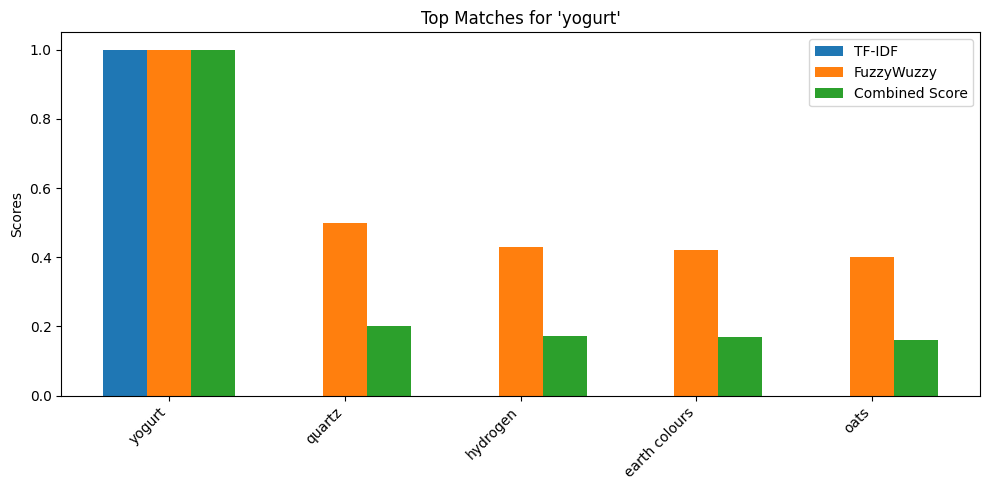


Product: yogurt
Method: Hybrid (Score: 1.00)
Description: yogurt
HS Code: 40310
Category: 4 - Dairy produce, birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included


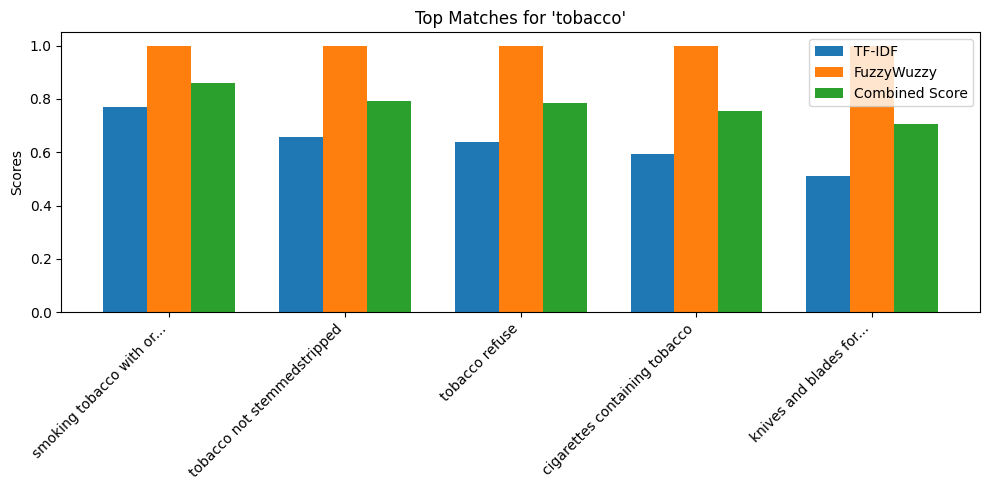


Product: tobacco
Method: Hybrid (Score: 0.86)
Description: smoking tobacco with or without tobacco substit
HS Code: 240310
Category: 24 - Tobacco and manufactured tobacco substitutes


In [ ]:
import matplotlib.pyplot as plt
import textwrap

def plot_scores(product_name, matches):
    """Visualize TF-IDF, Fuzzy, and Combined scores for top matches."""
    top_matches = sorted(matches, key=lambda x: x['combined_score'], reverse=True)[:5]

    labels = [textwrap.shorten(m['Description'], width=30, placeholder='...') for m in top_matches]
    tfidf_scores = [m['tfidf_score'] for m in top_matches]
    fuzz_scores = [m['fuzz_score'] for m in top_matches]
    combined_scores = [m['combined_score'] for m in top_matches]

    x = range(len(top_matches))
    width = 0.25

    plt.figure(figsize=(10, 5))
    plt.bar(x, tfidf_scores, width=width, label='TF-IDF', align='center')
    plt.bar([i + width for i in x], fuzz_scores, width=width, label='FuzzyWuzzy', align='center')
    plt.bar([i + 2 * width for i in x], combined_scores, width=width, label='Combined Score', align='center')

    plt.xticks([i + width for i in x], labels, rotation=45, ha='right')
    plt.title(f"Top Matches for '{product_name}'")
    plt.ylabel("Scores")
    plt.legend()
    plt.tight_layout()
    plt.show()

def hybrid_match(product_name, hs_data, tfidf, tfidf_matrix, tfidf_weight=0.6, fuzz_weight=0.4):
    """Improved hybrid match combining TF-IDF and FuzzyWuzzy results."""
    corrected_name = correct_spelling(product_name)
    input_vector = tfidf.transform([preprocess_text(corrected_name)])
    tfidf_scores = cosine_similarity(input_vector, tfidf_matrix)[0]

    # Get top 5 TF-IDF matches
    top_tfidf_indices = tfidf_scores.argsort()[-5:][::-1]
    tfidf_matches = [
        {
            'HS Code': hs_data.iloc[idx]['HS Code'],
            'Category': hs_data.iloc[idx]['Category'],
            'Description': hs_data.iloc[idx]['Description'],
            'Category_Description': hs_data.iloc[idx]['Category_Description'],
            'tfidf_score': tfidf_scores[idx]
        }
        for idx in top_tfidf_indices if tfidf_scores[idx] > 0
    ]

    # Get top 5 Fuzzy matches
    fuzz_matches = sorted([
        {
            'HS Code': row['HS Code'],
            'Category': row['Category'],
            'Description': row['Description'],
            'Category_Description': row['Category_Description'],
            'fuzz_score': fuzz.token_set_ratio(corrected_name, row['Description']) / 100
        }
        for _, row in hs_data.iterrows()
    ], key=lambda x: x['fuzz_score'], reverse=True)[:5]

    # Combine results
    combined_matches = []
    for match in tfidf_matches:
        fuzz_match = next((m for m in fuzz_matches if m['HS Code'] == match['HS Code']), None)
        fuzz_score = fuzz_match['fuzz_score'] if fuzz_match else 0
        combined_score = (tfidf_weight * match['tfidf_score']) + (fuzz_weight * fuzz_score)
        combined_matches.append({ **match, 'fuzz_score': fuzz_score, 'combined_score': combined_score })

    for match in fuzz_matches:
        if not any(m['HS Code'] == match['HS Code'] for m in tfidf_matches):
            desc_vector = tfidf.transform([preprocess_text(match['Description'])])
            tfidf_score = cosine_similarity(input_vector, desc_vector)[0][0]
            combined_score = (tfidf_weight * tfidf_score) + (fuzz_weight * match['fuzz_score'])
            combined_matches.append({ **match, 'tfidf_score': tfidf_score, 'combined_score': combined_score })

    if combined_matches:
        best_match = max(combined_matches, key=lambda x: x['combined_score'])
        if best_match['combined_score'] >= 0.3:
            plot_scores(product_name, combined_matches)  # Plot scores for visualization
            return best_match['HS Code'], best_match['Category'], best_match['Description'], best_match['Category_Description'], best_match['combined_score']

    return None, None, None, None, 0

def main():
    hs_file_path = 'hs_codes_preprocessed_pro.csv'
    category_file_path = 'hs_2_digit_categories_final.csv'
    hs_data = load_hs_data(hs_file_path, category_file_path)
    tfidf, tfidf_matrix = initialize_tfidf(hs_data)

    n = int(input("Enter the number of products: "))
    product_names = [input(f"Enter product name {i+1}: ") for i in range(n)]

    print("\nSelect matching method:")
    print("1. TF-IDF (semantic matching)")
    print("2. FuzzyWuzzy (typo tolerance)")
    print("3. Hybrid (best of both)")
    choice = int(input("Your choice (1-3): "))

    for product_name in product_names:
        if choice == 3:
            hs_code, category, desc, cat_desc, score = hybrid_match(product_name, hs_data, tfidf, tfidf_matrix)
            method = "Hybrid"
        elif choice == 1:
            hs_code, category, desc, cat_desc, score = tfidf_match(product_name, hs_data, tfidf, tfidf_matrix)
            method = "TF-IDF"
        else:
            hs_code, category, desc, cat_desc, score = fuzzy_match(product_name, hs_data)
            method = "FuzzyWuzzy"

        if hs_code:
            print(f"\nProduct: {product_name}")
            print(f"Method: {method} (Score: {score:.2f})")
            print(f"Description: {desc}")
            print(f"HS Code: {hs_code}")
            print(f"Category: {category} - {cat_desc}")
        else:
            print(f"\nNo match found for '{product_name}' (Method: {method})")

if __name__ == "__main__":
    main()


In [ ]:
pip install wordcloud matplotlib pandas


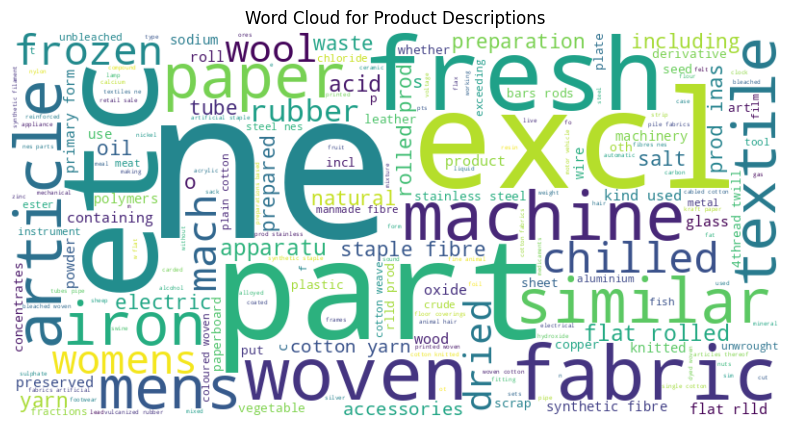

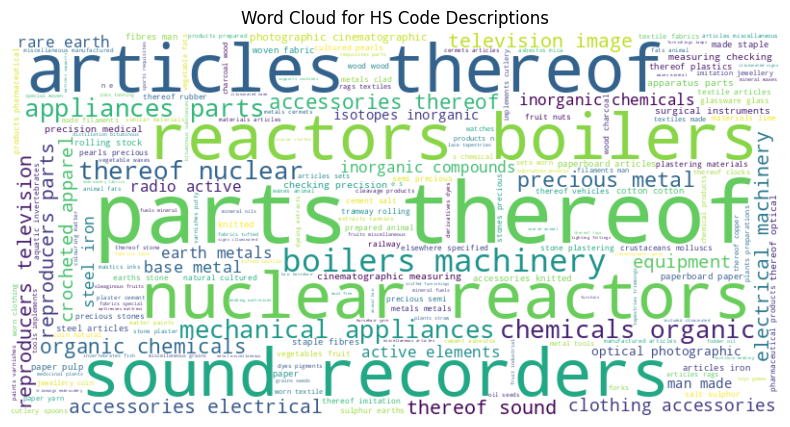

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load data (assuming your dataset is in a CSV file)
hs_file_path = 'hs_codes_preprocessed_pro.csv'  # Path to the HS Code dataset
category_file_path = 'hs_2_digit_categories_final.csv'  # Path to the Category dataset

# Load HS data and merge with category descriptions
def load_hs_data(file_path, category_file_path):
    hs_data = pd.read_csv(file_path)
    category_data = pd.read_csv(category_file_path)
    return pd.merge(hs_data, category_data, on='Category', how='left')

# Preprocess text (to remove non-alphabetical characters, and convert to lowercase)
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()  # Convert text to lowercase
    return " ".join(re.findall(r'\b\w+\b', text))  # Keep only words (no punctuation)

# Function to generate word cloud for descriptions
def generate_word_cloud(text_data, title="Word Cloud"):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Load the data
hs_data = load_hs_data(hs_file_path, category_file_path)

# Combine product descriptions and HS code descriptions
product_descriptions = hs_data['Description'].apply(preprocess_text).str.cat(sep=' ')  # All HS code descriptions
hs_code_descriptions = hs_data['Category_Description'].apply(preprocess_text).str.cat(sep=' ')  # Category descriptions

# Generate word clouds for product descriptions and HS code descriptions
generate_word_cloud(product_descriptions, "Word Cloud for Product Descriptions")
generate_word_cloud(hs_code_descriptions, "Word Cloud for HS Code Descriptions")


Enter number of test products: 3
Enter product name 1: yogurt
Enter actual HS code for 'yogurt': 40310
Enter product name 2: ginger
Enter actual HS code for 'ginger': 91010
Enter product name 3: vanilla
Enter actual HS code for 'vanilla': 90500


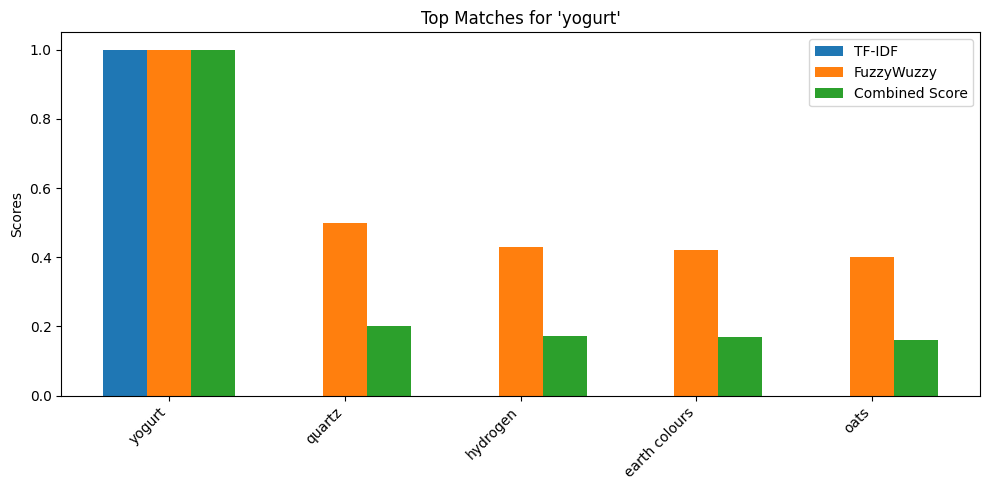

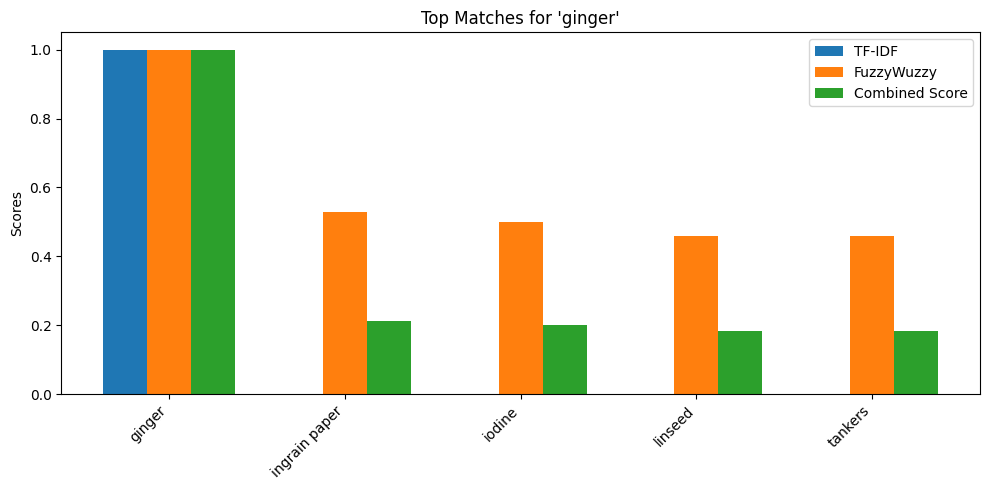

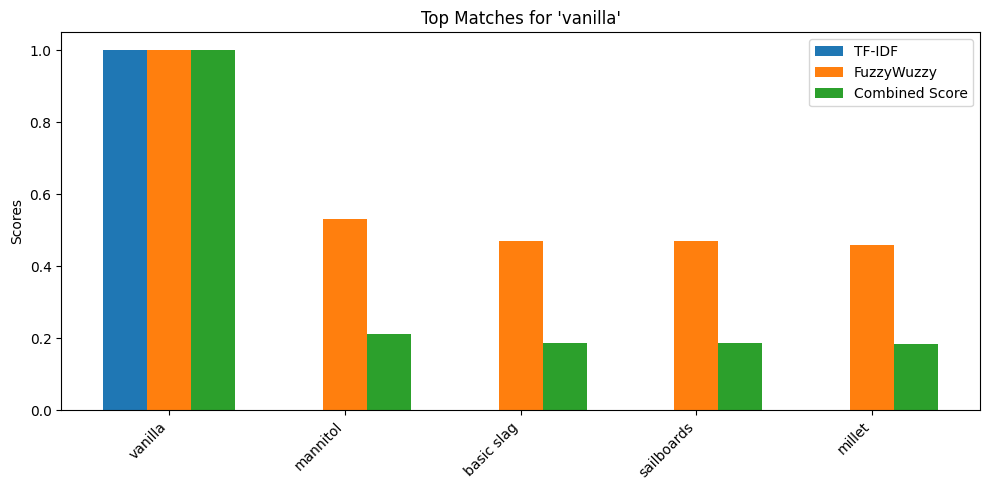

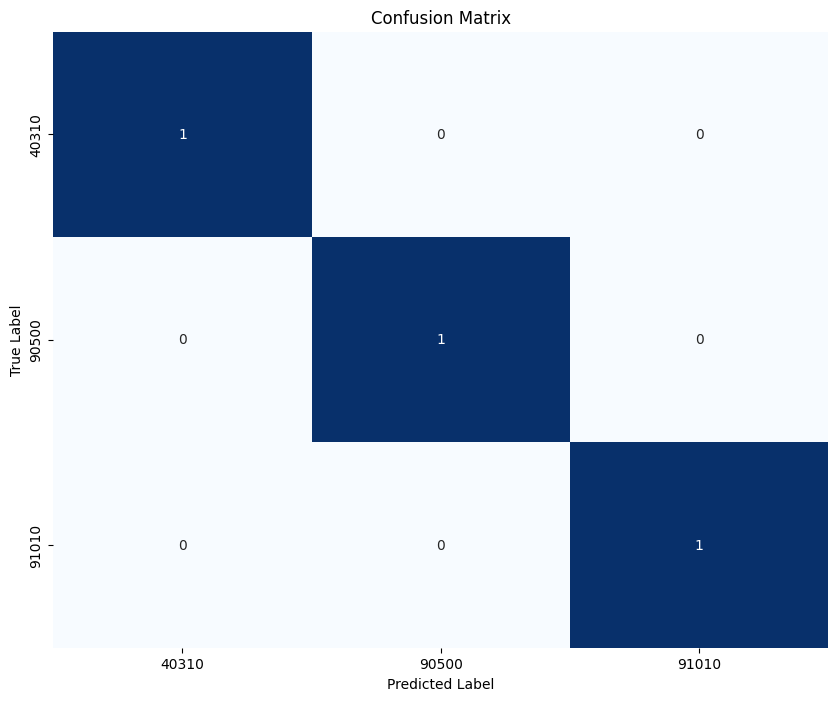

Classification Report:
              precision    recall  f1-score   support

       40310       1.00      1.00      1.00         1
       90500       1.00      1.00      1.00         1
       91010       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load your HS code and TF-IDF data (as you've already done)
hs_file_path = 'hs_codes_preprocessed_pro.csv'
category_file_path = 'hs_2_digit_categories_final.csv'
hs_data = load_hs_data(hs_file_path, category_file_path)
tfidf, tfidf_matrix = initialize_tfidf(hs_data)

# Step 1: Collect input and actual HS codes
n = int(input("Enter number of test products: "))
product_names = []
actual_hs_codes = []

for i in range(n):
    name = input(f"Enter product name {i+1}: ")
    actual = input(f"Enter actual HS code for '{name}': ")
    product_names.append(name)
    actual_hs_codes.append(actual)

# Step 2: Predict using hybrid model
predicted_hs_codes = []

for product_name in product_names:
    pred_hs_code, _, _, _, _ = hybrid_match(product_name, hs_data, tfidf, tfidf_matrix)
    predicted_hs_codes.append(str(pred_hs_code))  # Ensure consistency in type

# Step 3: Generate confusion matrix
labels = sorted(list(set(actual_hs_codes + predicted_hs_codes)))  # unique sorted labels
cm = confusion_matrix(actual_hs_codes, predicted_hs_codes, labels=labels)

# Step 4: Plot confusion matrix
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(cm, labels)

# Step 5: Print classification report
print("Classification Report:")
print(classification_report(actual_hs_codes, predicted_hs_codes, labels=labels, zero_division=0))


Enter number of products for evaluation: 3

Enter product name 1: ginger
Enter actual HS code for 'ginger': 91010

Product: ginger
Predicted HS Code: 91010
Actual HS Code: 91010
Match: ✅
Description: ginger
Category Description: Coffee, tea, maté and spices

Enter product name 2: frozen sole
Enter actual HS code for 'frozen sole': 30333

Product: frozen sole
Predicted HS Code: 30333
Actual HS Code: 30333
Match: ✅
Description: frozen sole
Category Description: Fish and crustaceans, molluscs and other aquatic invertebrates

Enter product name 3: live sheep
Enter actual HS code for 'live sheep': 10410

Product: live sheep
Predicted HS Code: 10410
Actual HS Code: 10410
Match: ✅
Description: live sheep
Category Description: Animals; live


=== Evaluation Report ===
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

       10410       1.00      1.00      1.00         1
       30333       1.00      1.00      1.00         1
       91010       1.00    

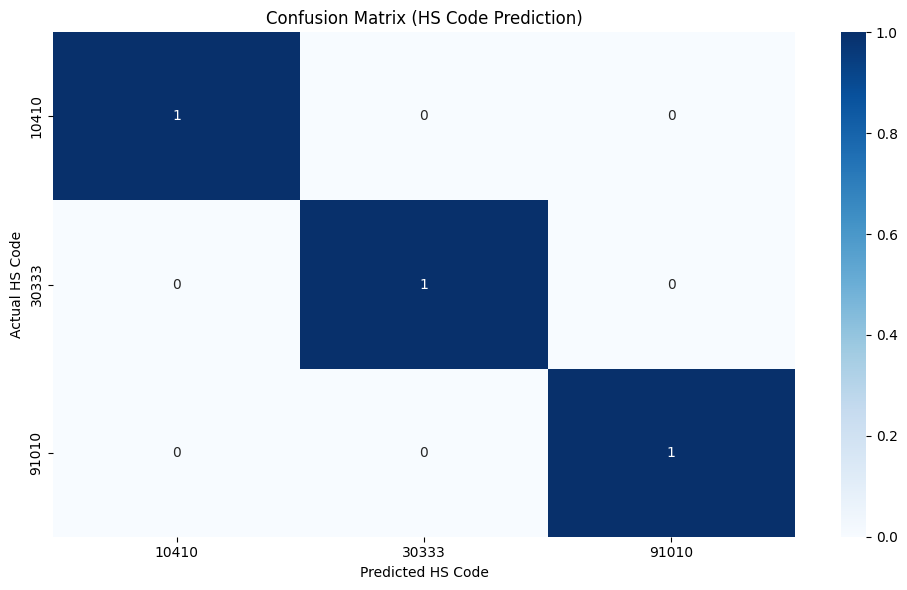

In [9]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def load_hs_data(file_path, category_file_path):
    """Load the HS code data and category description data from CSV files."""
    hs_data = pd.read_csv(file_path)
    category_data = pd.read_csv(category_file_path)
    merged_data = pd.merge(hs_data, category_data, on='Category', how='left')
    return merged_data

def preprocess_text(text):
    """Preprocess text by removing special characters and converting to lowercase."""
    if pd.isna(text):
        return ""
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

def find_hs_code(product_name, hs_data):
    """Find the closest matching HS code and category for a given product name."""
    processed_input = preprocess_text(product_name)
    input_words = set(processed_input.split())

    hs_data['processed_desc'] = hs_data['Description'].apply(preprocess_text)

    best_match = None
    best_score = 0

    for _, row in hs_data.iterrows():
        desc_words = set(row['processed_desc'].split())
        common_words = input_words.intersection(desc_words)
        score = len(common_words) / max(len(input_words), 1)

        if score > best_score:
            best_score = score
            best_match = row

    if best_match is not None and best_score > 0.3:
        return (best_match['HS Code'], best_match['Category'],
                best_match['Description'], best_match['Category_Description'])
    else:
        return None, None, None, None

def evaluate_manual_inputs(hs_data):
    """Evaluate the predictions by comparing with actual HS codes from user input."""
    n = int(input("Enter number of products for evaluation: "))

    y_true = []
    y_pred = []

    for i in range(n):
        product_name = input(f"\nEnter product name {i+1}: ")
        actual_hs_code = input(f"Enter actual HS code for '{product_name}': ")

        predicted_hs, category, desc, cat_desc = find_hs_code(product_name, hs_data)

        predicted_hs_str = str(predicted_hs) if predicted_hs else 'None'
        y_true.append(str(actual_hs_code))
        y_pred.append(predicted_hs_str)

        print(f"\nProduct: {product_name}")
        print(f"Predicted HS Code: {predicted_hs_str}")
        print(f"Actual HS Code: {actual_hs_code}")
        print(f"Match: {'✅' if predicted_hs_str == str(actual_hs_code) else '❌'}")
        print(f"Description: {desc}")
        print(f"Category Description: {cat_desc}")

    print("\n\n=== Evaluation Report ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    # Generate confusion matrix
    all_labels = sorted(list(set(y_true + y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    # Plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel('Predicted HS Code')
    plt.ylabel('Actual HS Code')
    plt.title('Confusion Matrix (HS Code Prediction)')
    plt.tight_layout()
    plt.show()

def main():
    hs_file_path = '/content/hs_codes_preprocessed_pro.csv'
    category_file_path = '/content/hs_2_digit_categories_final.csv'
    hs_data = load_hs_data(hs_file_path, category_file_path)
    evaluate_manual_inputs(hs_data)

if __name__ == "__main__":
    main()


Enter number of products: 3

Enter product name 1: sole frozen
Enter actual HS code for 'sole frozen': 30333
Predicted: 30333, Score: 1.00, Match: ✅

Enter product name 2: sheep live
Enter actual HS code for 'sheep live': 10410
Predicted: 10410, Score: 1.00, Match: ✅

Enter product name 3: crabs frozen
Enter actual HS code for 'crabs frozen': 30614
Predicted: 30614, Score: 1.00, Match: ✅

TF-IDF Classification Report:
              precision    recall  f1-score   support

       10410       1.00      1.00      1.00         1
       30333       1.00      1.00      1.00         1
       30614       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Accuracy: 1.0


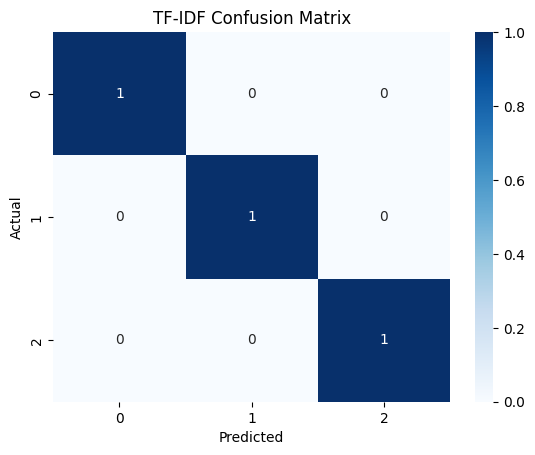

In [10]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess(text):
    if pd.isna(text):
        return ""
    return re.sub(r"[^\w\s]", "", str(text)).lower()

def load_data(hs_path, cat_path):
    hs = pd.read_csv(hs_path)
    cat = pd.read_csv(cat_path)
    return pd.merge(hs, cat, on='Category', how='left')

def tfidf_match(product_name, hs_data, tfidf, tfidf_matrix):
    input_vector = tfidf.transform([preprocess(product_name)])
    similarities = cosine_similarity(input_vector, tfidf_matrix)[0]
    top_idx = similarities.argmax()
    best_score = similarities[top_idx]
    if best_score >= 0.3:
        row = hs_data.iloc[top_idx]
        return str(row['HS Code']), row['Description'], best_score
    return "None", None, 0

def evaluate_tfidf(hs_data):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(hs_data['Description'].apply(preprocess))

    n = int(input("Enter number of products: "))
    y_true, y_pred = [], []

    for i in range(n):
        prod = input(f"\nEnter product name {i+1}: ")
        true_code = input(f"Enter actual HS code for '{prod}': ")
        pred_code, desc, score = tfidf_match(prod, hs_data, tfidf, tfidf_matrix)

        print(f"Predicted: {pred_code}, Score: {score:.2f}, Match: {'✅' if pred_code == true_code else '❌'}")
        y_true.append(true_code)
        y_pred.append(pred_code)

    print("\nTF-IDF Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("Accuracy:", accuracy_score(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("TF-IDF Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Paths
hs_path = "hs_codes_preprocessed_pro.csv"
cat_path = "hs_2_digit_categories_final.csv"
hs_data = load_data(hs_path, cat_path)
evaluate_tfidf(hs_data)


Enter number of products: 3

Enter product name 1: yogert
Enter actual HS code for 'yogert': 40310
Predicted: 40310, Score: 0.83, Match: ✅

Enter product name 2: frozen sale
Enter actual HS code for 'frozen sale': 30333
Predicted: 30333, Score: 0.91, Match: ✅

Enter product name 3: ganger
Enter actual HS code for 'ganger': 91010
Predicted: 91010, Score: 0.83, Match: ✅

FuzzyWuzzy Classification Report:
              precision    recall  f1-score   support

       30333       1.00      1.00      1.00         1
       40310       1.00      1.00      1.00         1
       91010       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Accuracy: 1.0


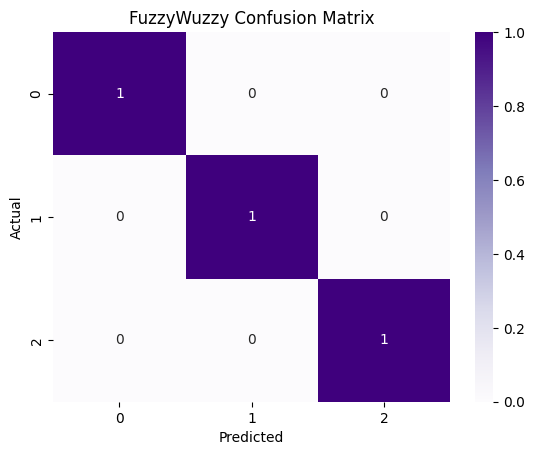

In [11]:
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt

def fuzzy_match(product_name, hs_data):
    scores = hs_data['Description'].apply(lambda x: fuzz.token_set_ratio(product_name.lower(), str(x).lower()))
    top_idx = scores.idxmax()
    best_score = scores[top_idx] / 100
    if best_score >= 0.3:
        row = hs_data.iloc[top_idx]
        return str(row['HS Code']), row['Description'], best_score
    return "None", None, 0

def evaluate_fuzzy(hs_data):
    n = int(input("Enter number of products: "))
    y_true, y_pred = [], []

    for i in range(n):
        prod = input(f"\nEnter product name {i+1}: ")
        true_code = input(f"Enter actual HS code for '{prod}': ")
        pred_code, desc, score = fuzzy_match(prod, hs_data)

        print(f"Predicted: {pred_code}, Score: {score:.2f}, Match: {'✅' if pred_code == true_code else '❌'}")
        y_true.append(true_code)
        y_pred.append(pred_code)

    print("\nFuzzyWuzzy Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("Accuracy:", accuracy_score(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
    plt.title("FuzzyWuzzy Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Paths
hs_data = load_data(hs_path, cat_path)
evaluate_fuzzy(hs_data)


Enter number of products: 3

Enter product name 1: Yogurt is a creamy, tangy dairy product made by fermenting milk with beneficial bacteria.
Enter actual HS code for 'Yogurt is a creamy, tangy dairy product made by fermenting milk with beneficial bacteria.': 40310
Predicted: 40310, Score: 0.72, Match: ✅

Enter product name 2: Ginger is a spicy, aromatic root commonly used in cooking and traditional medicine.
Enter actual HS code for 'Ginger is a spicy, aromatic root commonly used in cooking and traditional medicine.': 91010
Predicted: 91010, Score: 0.68, Match: ✅

Enter product name 3: Frozen sole is a type of flatfish that is commonly found in colder waters
Enter actual HS code for 'Frozen sole is a type of flatfish that is commonly found in colder waters': 30333
Predicted: 30333, Score: 0.81, Match: ✅

Hybrid Classification Report:
              precision    recall  f1-score   support

       30333       1.00      1.00      1.00         1
       40310       1.00      1.00      1.00  

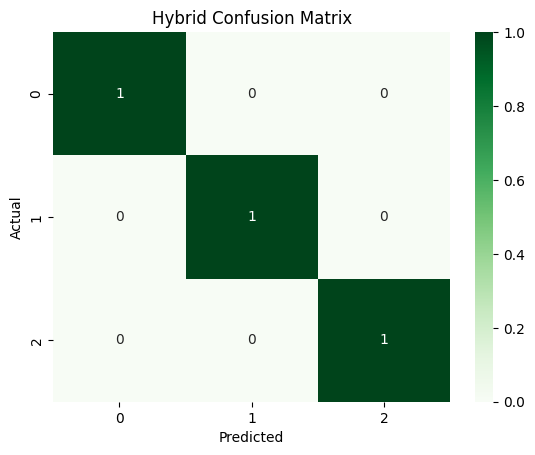

In [12]:
def hybrid_match(product_name, hs_data, tfidf, tfidf_matrix, tfidf_weight=0.6, fuzz_weight=0.4):
    input_vector = tfidf.transform([preprocess(product_name)])
    tfidf_scores = cosine_similarity(input_vector, tfidf_matrix)[0]

    matches = []
    for idx, row in hs_data.iterrows():
        fuzz_score = fuzz.token_set_ratio(product_name.lower(), str(row['Description']).lower()) / 100
        tfidf_score = tfidf_scores[idx]
        combined = tfidf_weight * tfidf_score + fuzz_weight * fuzz_score
        matches.append((combined, str(row['HS Code']), row['Description']))

    matches.sort(reverse=True)
    best_score, best_code, desc = matches[0]
    if best_score >= 0.3:
        return best_code, desc, best_score
    return "None", None, 0

def evaluate_hybrid(hs_data):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(hs_data['Description'].apply(preprocess))

    n = int(input("Enter number of products: "))
    y_true, y_pred = [], []

    for i in range(n):
        prod = input(f"\nEnter product name {i+1}: ")
        true_code = input(f"Enter actual HS code for '{prod}': ")
        pred_code, desc, score = hybrid_match(prod, hs_data, tfidf, tfidf_matrix)

        print(f"Predicted: {pred_code}, Score: {score:.2f}, Match: {'✅' if pred_code == true_code else '❌'}")
        y_true.append(true_code)
        y_pred.append(pred_code)

    print("\nHybrid Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("Accuracy:", accuracy_score(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title("Hybrid Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Paths
hs_data = load_data(hs_path, cat_path)
evaluate_hybrid(hs_data)
